In [1]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import pickle 

C:\Users\Partha\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.
C:\Users\Partha\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Partha\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Partha\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of 

In [2]:
#importing the dataset
data_full = pd.read_excel('Associate Insights.xlsx')
data_full.head()

,Date,Sentiment,HandleName,Store Name,Comment
0,2019-02-20,Concern,Surface,"0071 - Edmonton, AB",A female customer made a comment on our select...
1,2019-02-20,Concern,Surface,0006 - Bellevue,Comments from customer today were that they wo...
2,2019-02-20,Concern,Surface,0006 - Bellevue,Customer came in asking today if there was any...
3,2019-02-20,Concern,Surface,8014 - Washington Square,Customer had an issue with their Surface Lapto...
4,2019-02-20,Concern,Surface,0039 - Dadeland Mall,Customer name Patricia passed by the Store bou...


In [3]:
#adding the predictor field
data_full['Score'] = data_full["Sentiment"].apply(lambda x: 0 if x == 'Concern' else 1 if x == 'Positive' else 2)
data_full.head()

,Date,Sentiment,HandleName,Store Name,Comment,Score
0,2019-02-20,Concern,Surface,"0071 - Edmonton, AB",A female customer made a comment on our select...,0
1,2019-02-20,Concern,Surface,0006 - Bellevue,Comments from customer today were that they wo...,0
2,2019-02-20,Concern,Surface,0006 - Bellevue,Customer came in asking today if there was any...,0
3,2019-02-20,Concern,Surface,8014 - Washington Square,Customer had an issue with their Surface Lapto...,0
4,2019-02-20,Concern,Surface,0039 - Dadeland Mall,Customer name Patricia passed by the Store bou...,0


In [4]:
data_full = data_full[['Sentiment', 'Comment', 'Score']]
data_full.tail(10)

,Sentiment,Comment,Score
50089,General,Please add the processor type and RAM to the b...,2
50090,General,TypeCovers for Microsoft Studio games or even ...,2
50091,Positive,I love the Apps Now site! It's a great idea t...,1
50092,Positive,Customers LOVE the HTC vive. They always leave...,1
50093,Concern,The techs need to be trained to better support...,0
50094,General,Surface Dial should have customized Commands o...,2
50095,Concern,Customers are upset when they break their phon...,0
50096,Concern,We have completed a slew of Band exchanges for...,0
50097,Concern,Will the Xbox Elite Controller work with proje...,0
50098,Concern,"With Xbox Play Anywhere becoming more popular,...",0


In [5]:
data_full.describe()

,Score
count,50099.000000
mean,0.495918
std,0.532281
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [6]:
#using regular expression to clean the data 

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df
data = standardize_text(data_full, "Comment")
data.to_csv("clean_data.csv")


In [7]:
data.head()

,Sentiment,Comment,Score
0,Concern,a female customer made a comment on our select...,0
1,Concern,comments from customer today were that they wo...,0
2,Concern,customer came in asking today if there was any...,0
3,Concern,customer had an issue with their surface lapto...,0
4,Concern,customer name patricia passed by the store bou...,0


In [8]:
clean_data = pd.read_csv("clean_data.csv")
clean_data[['Comment']] = clean_data[['Comment']].astype(str)

clean_data.head(10)

,Unnamed: 0,Sentiment,Comment,Score
0,0,Concern,a female customer made a comment on our select...,0
1,1,Concern,comments from customer today were that they wo...,0
2,2,Concern,customer came in asking today if there was any...,0
3,3,Concern,customer had an issue with their surface lapto...,0
4,4,Concern,customer name patricia passed by the store bou...,0
5,5,Concern,customer says they have been losing her pen us...,0
6,6,Concern,customer would like the surface pro to have a ...,0
7,7,Concern,customers have been asking about a surface pro...,0
8,8,Concern,device tech specs on microsoft com should list...,0
9,9,Concern,microsoft fte discount on surface headphones i...,0


In [9]:
clean_data.groupby("Score").count()

,Unnamed: 0,Sentiment,Comment
Score,,,
0,26089,26089,26089
1,23175,23175,23175
2,835,835,835


The positive and negative categories are well-balanced in the dataset. 

In [10]:
#Preparing the data
#tokenizing 

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_data["tokens"] = clean_data["Comment"].apply(tokenizer.tokenize)
clean_data.head()

,Unnamed: 0,Sentiment,Comment,Score,tokens
0,0,Concern,a female customer made a comment on our select...,0,"[a, female, customer, made, a, comment, on, ou..."
1,1,Concern,comments from customer today were that they wo...,0,"[comments, from, customer, today, were, that, ..."
2,2,Concern,customer came in asking today if there was any...,0,"[customer, came, in, asking, today, if, there,..."
3,3,Concern,customer had an issue with their surface lapto...,0,"[customer, had, an, issue, with, their, surfac..."
4,4,Concern,customer name patricia passed by the store bou...,0,"[customer, name, patricia, passed, by, the, st..."


In [11]:
#Inspection 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_data["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

1752903 words total, with a vocabulary size of 19384
Max sentence length is 360


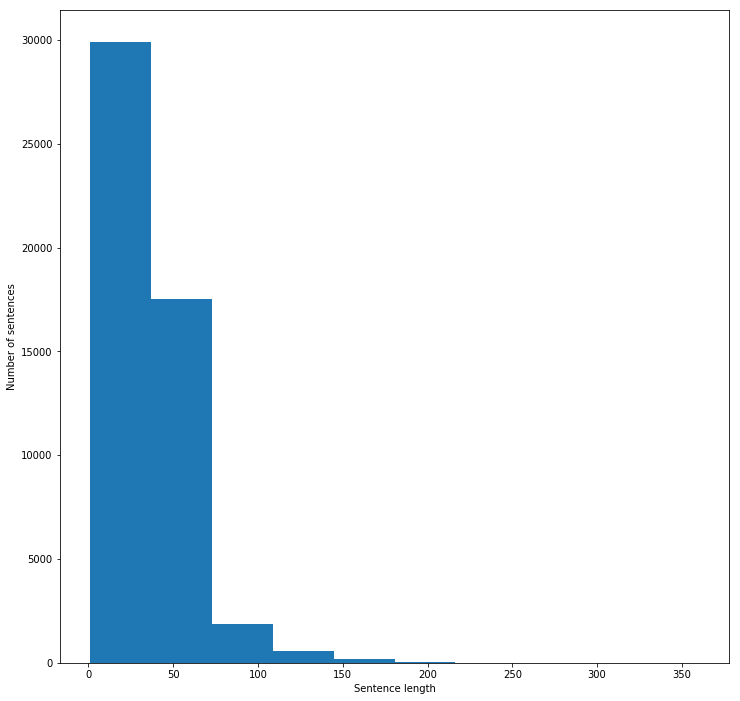

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [14]:
#bag of words model
#modeling using sparcity matrix

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = clean_data["Comment"].tolist()
list_labels = clean_data["Score"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [16]:
#Classifying
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [17]:
#Evaluating Classifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives + false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')
    
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives / total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.810, precision = 0.824, recall = 0.810, f1 = 0.817


In [18]:
#Confusion Matrix

import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.summer):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

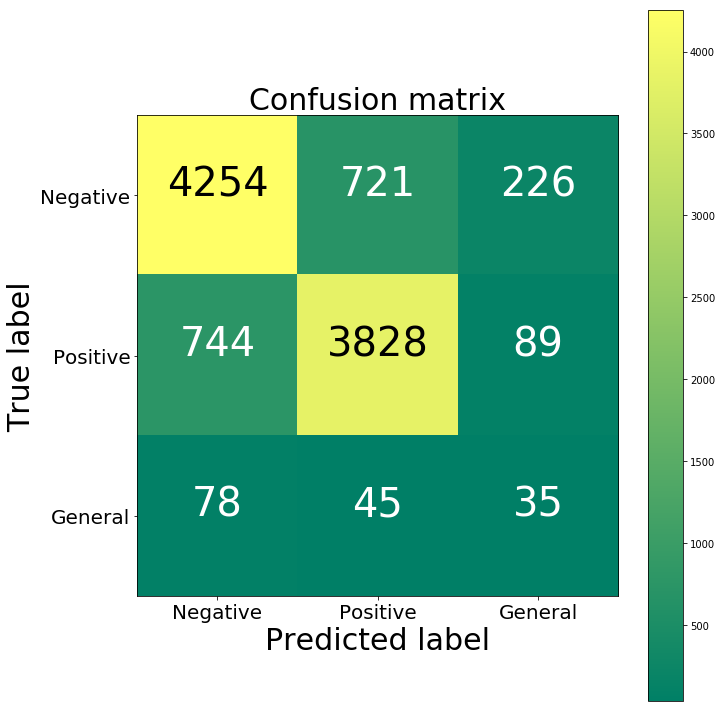

[[4254  721  226]
 [ 744 3828   89]
 [  78   45   35]]


In [19]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Positive','General'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

84% accurracy 

In [20]:
#top 10 features for each category 


def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 30)

In [21]:
importance

{0: {'tops': [(4.268668830690042, 'navigater'),
   (4.279287779052006, 'activation'),
   (4.294422164307855, 'bothered'),
   (4.329713646090557, 'veteran'),
   (4.3518771998872205, 'layering'),
   (4.392514328684344, 'wasted'),
   (4.414037041147338, 'accept'),
   (4.430618234238752, 'pointer'),
   (4.454813902716149, 'battlelfield'),
   (4.460905951956503, '1080'),
   (4.466573384528622, 'deducts'),
   (4.481820132044878, 'fulltime'),
   (4.485699661806541, 'surfacebook2'),
   (4.499421394254271, 'g72'),
   (4.520788521066291, 'stools'),
   (4.539007388842114, 'upright'),
   (4.619225409541681, 'involves'),
   (4.794659792302004, 'antendees'),
   (4.83185247281044, 'weekdays'),
   (4.880757462079422, 'trash'),
   (5.122846431667299, 'liners'),
   (5.215109848481047, 'bumper'),
   (5.244228169293655, 'concerning'),
   (5.415988534747804, 'difficulty'),
   (5.477251112495075, 'nail'),
   (5.654886380831366, 'shipments'),
   (5.692095059755234, 'immense'),
   (5.741123861272039, 'aspire'

In [22]:
import pickle 

In [23]:
top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
with open("positive.txt", "wb") as fp:
    pickle.dump(top_words, fp)

bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]
with open("negative.txt", "wb") as fp:
    pickle.dump(bottom_words, fp)

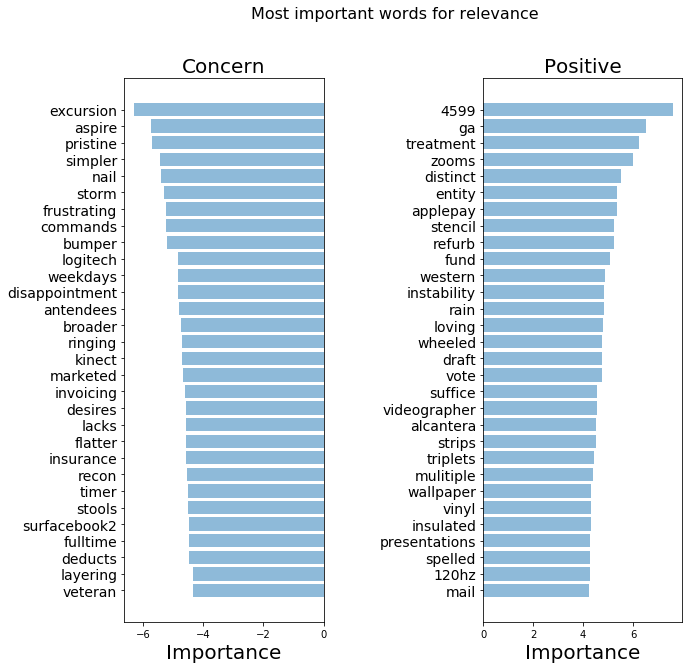

In [24]:
# to display the most frequently used neg and pos words as a bar chart

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]    
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10
                             ))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Concern', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()
    
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")
    

Concern words seem ok, but the positive words do not make any sense at all 

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# word cloud of positive words

with open("positive.txt", "rb") as fp:
    positive_list = pickle.load(fp)
    positive_list = positive_list[::-1]
    

def show_wordcloud_pos(data, title = None):

    wordcloud = WordCloud(
        background_color = 'white', colormap = 'Blues',
        max_words = 200,
        max_font_size = 40, collocations=False,
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

# wordcloud of negative words

with open("negative.txt", "rb") as fp:
    negative_list = pickle.load(fp)
    negative_list = negative_list[::-1]
    
def show_wordcloud_neg(data, title = None):

    wordcloud = WordCloud(
        background_color = 'white', colormap = matplotlib.cm.inferno,
        max_words = 200,
        max_font_size = 40, collocations=False,
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    


In [26]:
# print positive wordcloud

#show_wordcloud_pos(positive_list)

In [27]:
# print negative wordcloud

# show_wordcloud_neg(negative_list)

In [28]:
#trying to model using term frequency method

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [30]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [31]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.828, precision = 0.841, recall = 0.828, f1 = 0.834


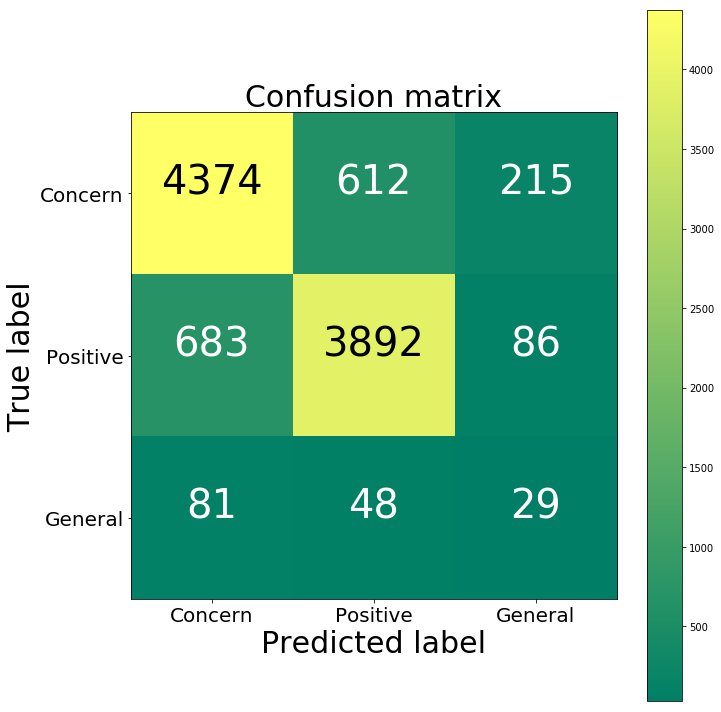

TFIDF confusion matrix
[[4374  612  215]
 [ 683 3892   86]
 [  81   48   29]]
BoW confusion matrix
[[4254  721  226]
 [ 744 3828   89]
 [  78   45   35]]


In [32]:

cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Concern','Positive','General'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

86% accuracy, slight increase in accuracy but more true positives and true negatives

In [33]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 50)

In [34]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
with open("pos_tfidf.txt", "wb") as fp:
    pickle.dump(top_words, fp)

bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]
with open("neg_tfidf.txt", "wb") as fp:
    pickle.dump(bottom_words, fp)


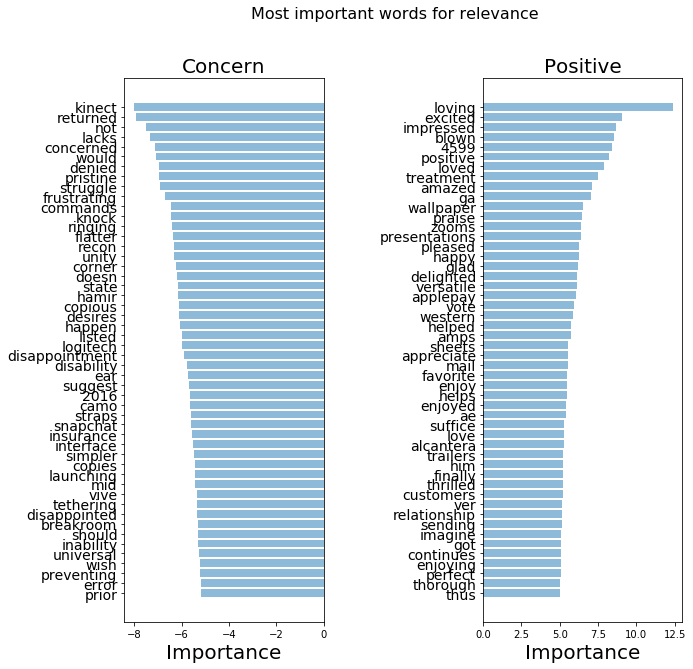

In [35]:
# to plot the most relevant words as a bar chart

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

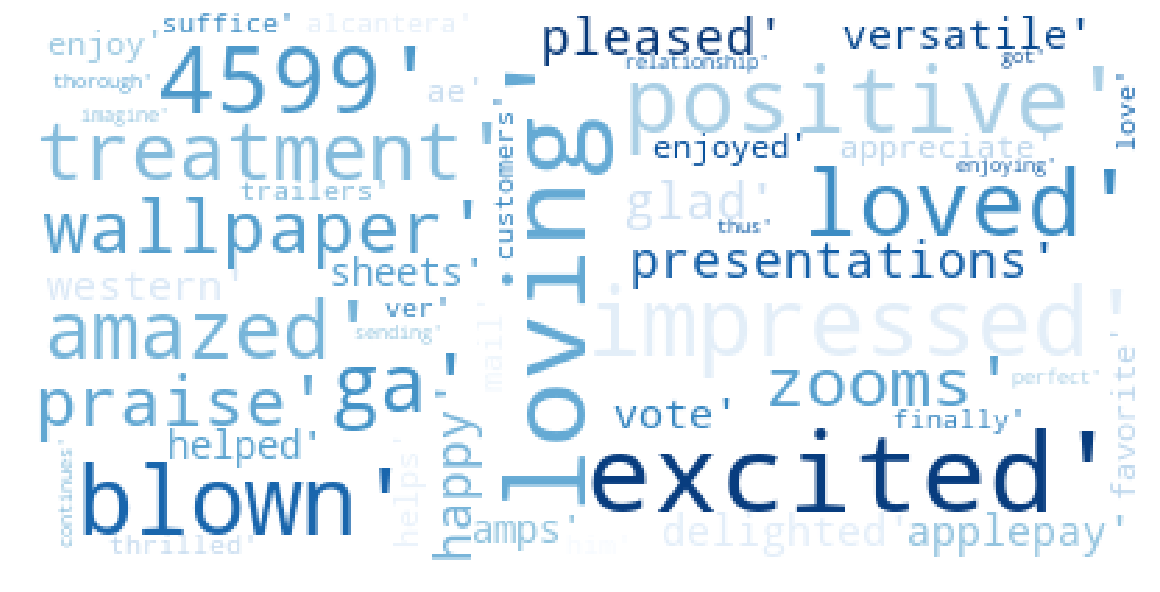

In [64]:
# wordcloud of positive words

with open("pos_tfidf.txt", "rb") as fp:
    pos_tfidf_list = pickle.load(fp)
    pos_tfidf_list = pos_tfidf_list[::-1]

show_wordcloud_pos(pos_tfidf_list)

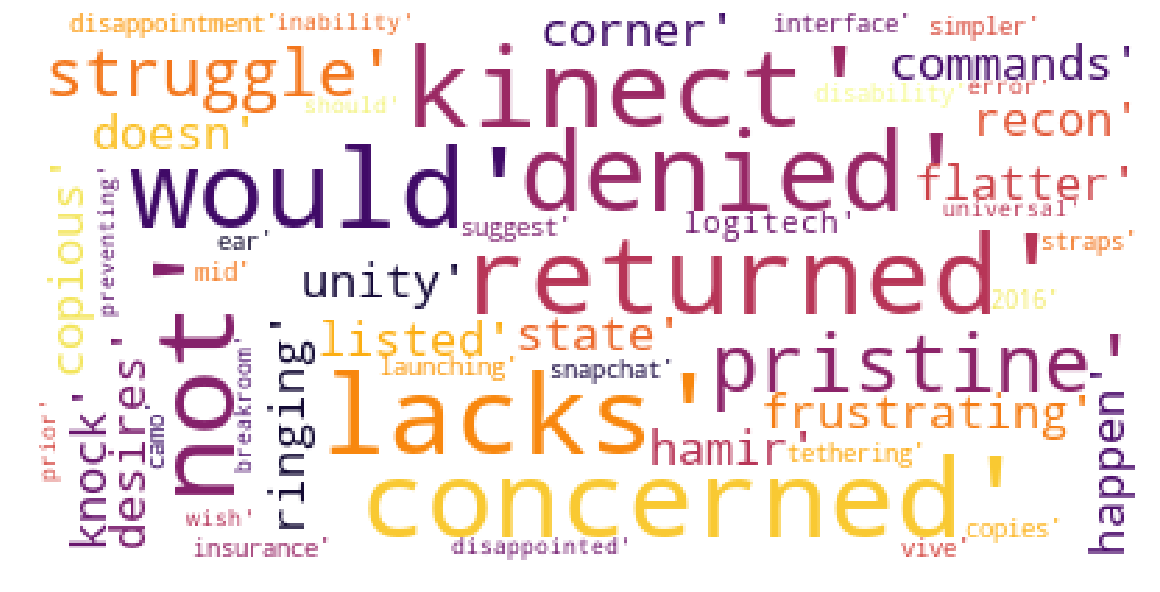

In [65]:
# wordcloud of negative words

with open("neg_tfidf.txt", "rb") as fp:
    neg_tfidf_list = pickle.load(fp)
    neg_tfidf_list = neg_tfidf_list[::-1]
    
show_wordcloud_neg(neg_tfidf_list)

Much better split of key words than before.

In [44]:
#taking into account the semantics of a sentence using word2vec

import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin"

word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

C:\Users\Partha\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [45]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_data, generate_missing=False):
    embeddings = clean_data['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [31]:
embeddings = get_word2vec_embeddings(word2vec, clean_data)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

In [33]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [34]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.714, precision = 0.829, recall = 0.714, f1 = 0.762


This drop in the accuracy is due to the involvement of the generic terms which skew the accuracy

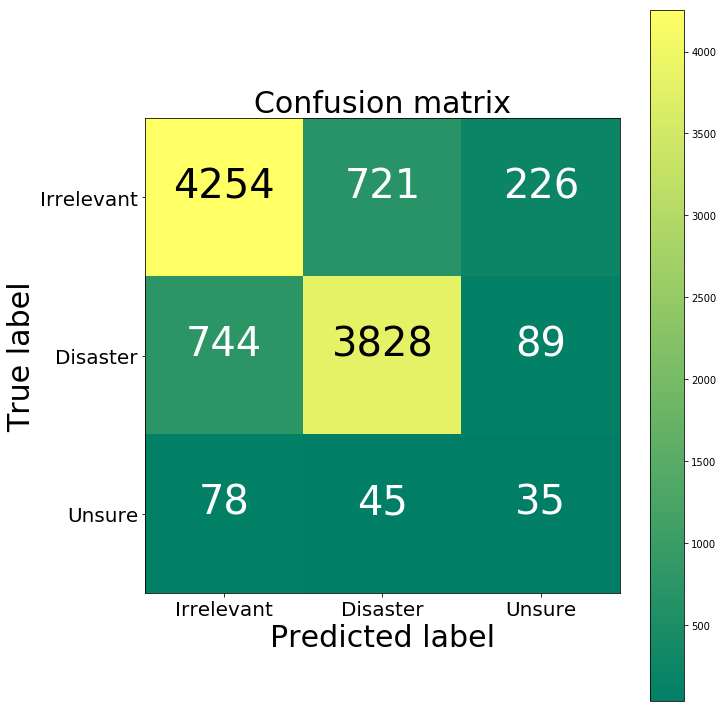

Word2Vec confusion matrix
[[3418  697 1086]
 [ 563 3652  446]
 [  49   28   81]]
TFIDF confusion matrix
[[4374  612  215]
 [ 683 3892   86]
 [  81   48   29]]
BoW confusion matrix
[[4254  721  226]
 [ 744 3828   89]
 [  78   45   35]]


In [35]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [37]:
from lime.lime_text import LimeTextExplainer

In [38]:
from sklearn.pipeline import make_pipeline


In [39]:
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

In [40]:
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [41]:

def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["Concern","Positive", "General"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [42]:
visualize_one_exp(X_test_data, y_test_data, 30)

Index: 30
True class: Concern


In [43]:
visualize_one_exp(X_test_data, y_test_data, 60)

Index: 60
True class: Positive


In [44]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Concern',
    1: 'Positive',
    2: 'General'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

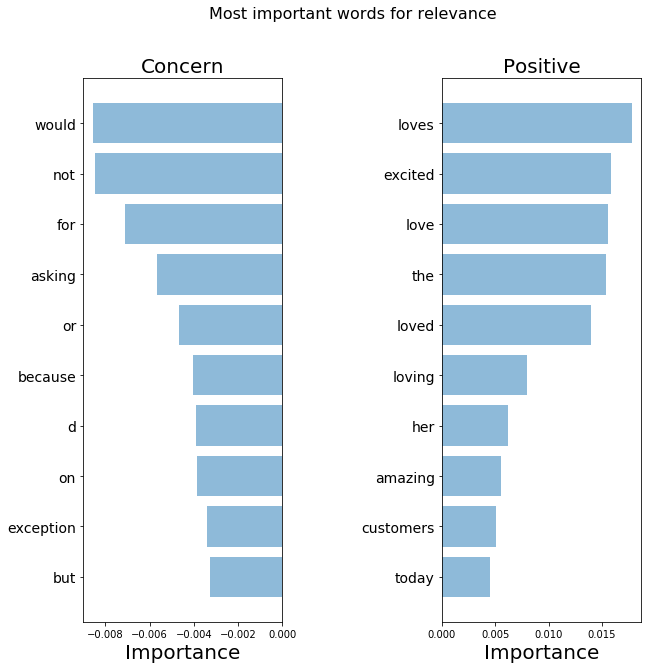

In [45]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Positive']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Positive']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Positive']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Positive']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [46]:
#Focusing on text structure

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_data["Comment"].tolist())
sequences = tokenizer.texts_to_sequences(clean_data["Comment"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(clean_data["Score"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 20365 unique tokens.
(20366, 300)


In [47]:
from keras.layers import Concatenate
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    #l_merge = Merge(mode='concat', concat_axis=1)(convs)
    l_merge = keras.layers.Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [48]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, len(list(clean_data["Score"].unique())), False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [49]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs = 4)

Instructions for updating:
Use tf.cast instead.
Train on 40080 samples, validate on 10019 samples
Epoch 1/4
40080/40080 [==============================] - 86s 2ms/step - loss: 0.4530 - acc: 0.8215 - val_loss: 0.4363 - val_acc: 0.8290.
Epoch 3/4
40080/40080 [==============================] - 86s 2ms/step - loss: 0.3697 - acc: 0.8561 - val_loss: 0.4185 - val_acc: 0.8357
